## Installing / Importing Packages

The following packages are required for the notebook to work.

In [ ]:
# !git clone https://github.com/fizyr/keras-retinanet.git

In [ ]:
# !pip install keras==2.15.0
# !pip install gast==0.2.2
# !pip install protobuf==3.17.3
# !pip install tensorboard==2.10.0
# !pip install tensorflow-estimator==2.10.0

In [ ]:
# !pip install -r ./keras-retinanet/requirements.txt

In [1]:
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as ET
from keras_retinanet.utils.visualization import draw_box, draw_caption , label_color
from keras_retinanet.utils.image import preprocess_image, resize_image
from os.path import isfile, join
import matplotlib.pyplot as plt
import urllib
from os import listdir
import glob
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
import time
from keras_retinanet import models
from PIL import Image, ImageDraw, ImageFont
import csv
import tensorflow as tf

In [2]:
#Checking the version of tensorflow
tf.__version__

#Checking if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
    for gpu in gpus:
        print("Device name:", gpu.name)
else:
    print("No GPU available, using CPU instead")

GPU is available
Device name: /physical_device:GPU:0


## Setting up Files and Folders

Before training the models, a few changes are to be made to set up the Training Files to be utilised in the project. The main changes done in this code is updating of file paths to ensure proper training.

In [3]:
#Setting the path for the images and annotations
jpgPath="../Object_Detection_Dataset/CSV/Train/images"
annPath="../Object_Detection_Dataset/CSV/Train/labels.csv"

In [4]:
#Creating a folder to save the snapshots
if not os.path.exists('snapshots'):
  os.mkdir('snapshots')

## Retrieving the Unique Labels from CSV Function

This function takes two input parameters:

- **csvPath** - The location of the filename to retrieve information from.
- **index** - The column of the file to search through.

The file is first opened and the unique values from the column indicated by the index are retrieved and returned as a set.

In [5]:
#Defining a function to get the unique values from a CSV file's column
def get_unique_values_from_csv(csvPath, index):
    unique_values = set()
    #Opening the CSV file
    with open(csvPath, 'r') as file:
        reader = csv.reader(file)
        #Iterating through the rows of the CSV file
        for row in reader:
            #Checking if the row has the required index
            if len(row) > index:
                unique_values.add(row[index])
    return unique_values


column_index = 5 
unique_values = get_unique_values_from_csv(annPath, column_index)
print("Unique Values:", unique_values)

Unique Values: {'wow', 'care', 'love', 'angry', 'haha', 'like', 'sad'}


## Inserting Information to CSV File Column

This function takes three input parameters:

- **csvFile** - The location of the filename to retrieve information from.
- **directoryName** - The information to be inserted. 
- **columnIndex** - The column of the file to insert through.

The file is first opened and all values are rewritted with the directoryName parameter concatenated with them. The file is then saved.

In [6]:
#Defining a function to append the directory name to the column
def appendDirectoryToColumn(csvFile, directoryName, columnIndex):
    #Reading the CSV file and storing its contents
    with open(csvFile, 'r') as file:
        reader = csv.reader(file)
        rows = list(reader)

    #Appending the directory name to each value in the specified column
    for row in rows:
        row[columnIndex] = directoryName + row[columnIndex]

    #Writing the modified data back to the CSV file
    with open(csvFile, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(rows)

appendDirectoryToColumn(annPath, "images/", 0)

In [7]:
#Creating a file to save the labels
with open('./Classes.csv', 'w') as file:
  for i, class_name in enumerate(unique_values):
    file.write(f'{class_name},{i}\n') 

## Installing and Loading Model

The model is first downloaded and has a few of its files altered. The reason behind these file changes was for evaluation purposes later on in the document.

In [ ]:
#Downloading the pre-trained model
url = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
model = './snapshots/resnet50_csv_v1.h5'
urllib.request.urlretrieve(url, model)

## Function to Replace Files

This function takes two parameters:

- **file_a** - The file to replace it with.
- **file_b** - The file to be replaced.

The file is overwritten by the other file's contents. This is used for evaluation purposes later on in the notebook.

In [8]:
#Defining the function to replace the contents of a file
def copy_and_replace(file_a, file_b):
    try:
        #Reading the contents of the first file
        with open(file_a, 'r') as file_a_contents:
            data = file_a_contents.read()
        #Writing the contents of the first file to the second file
        with open(file_b, 'w') as file_b_contents:
            file_b_contents.write(data)

        print(f"Contents of {file_a} copied and replaced in {file_b} successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
#Replacing the files in the keras-retinanet library
evaluation_path = "./filesToReplace/modified_evaluate.py"
evaluation_copyTo_path = "./keras-retinanet/keras_retinanet/bin/evaluate.py"

eval_path = "./filesToReplace/modified_eval.py"
eval_copyTo_path = "./keras-retinanet/keras_retinanet/utils/eval.py"

visualise_path = "./filesToReplace/visualization.py"
visualise_copyTo_path= "./keras-retinanet/keras_retinanet/utils/visualization.py"

copy_and_replace(evaluation_path, evaluation_copyTo_path)
copy_and_replace(eval_path, eval_copyTo_path)
copy_and_replace(visualise_path, visualise_copyTo_path)

## Training Model

The model is trained for 10 epochs, following that the model is saved and loaded.

In [3]:
#Training the model
!python keras-retinanet/keras_retinanet/bin/train.py \
        --freeze-backbone --random-transform --gpu 0 --weights ./snapshots/resnet50_csv_v1.h5 \
         --batch-size 4 --steps 250 --epochs 10 --tensorboard-dir tensorboard csv ../Object_Detection_Dataset/CSV/Train/labels.csv ./Classes.csv

1 Physical GPUs, 1 Logical GPUs
Creating model, this may take a second...
Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, None, None,   256         ['conv1[0][0]']                  
                

2024-05-17 09:37:05.232924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 09:37:06.227056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3472 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
c:\Users\icemo\anaconda3\envs\retinanetTraining\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instanc

In [4]:
#Selecting the latest model
print(glob.glob('./snapshots/*.h5'))
model_path = glob.glob('./snapshots/*.h5')[-2]

#Loading the model
print(model_path)
model = models.load_model(model_path, backbone_name='resnet50')

['./snapshots\\resnet50_csv_01.h5', './snapshots\\resnet50_csv_02.h5', './snapshots\\resnet50_csv_03.h5', './snapshots\\resnet50_csv_04.h5', './snapshots\\resnet50_csv_05.h5', './snapshots\\resnet50_csv_06.h5', './snapshots\\resnet50_csv_07.h5', './snapshots\\resnet50_csv_08.h5', './snapshots\\resnet50_csv_09.h5', './snapshots\\resnet50_csv_10.h5', './snapshots\\resnet50_csv_v1.h5']
./snapshots\resnet50_csv_10.h5


c:\Users\icemo\anaconda3\envs\retinanetTraining\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


## Human Evaluation

The model is tested on a few unseen examples which are displayed to the user for human verification of the performance of the model.

In [ ]:
# # For prediction (To properly visualize the bounding boxes)
# visualise_path_1 = "./filesToReplace/visualization.py"
# visualise_copyTo_path= "./keras-retinanet/keras_retinanet/utils/visualization.py"

# copy_and_replace(visualise_path_1, visualise_copyTo_path)

In [5]:
#Creating a folder to save the inference images
img_save_path = './inference_images'

if not os.path.exists(img_save_path):
    os.makedirs(img_save_path)

#Loading the model and converting it
model = models.load_model(glob.glob('./snapshots/*.h5')[-2], backbone_name='resnet50')
model = models.convert_model(model)

#Loading the classes
labels_to_names = pd.read_csv("./Classes.csv",header=None).T.loc[0].to_dict()

In [7]:
#Appending the directory name to the column of the test CSV file
annPath="../Object_Detection_Dataset/CSV/Test/labels.csv"
appendDirectoryToColumn(annPath, "images/", 0)

In [8]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

#Selecting five images from the test folder
test_path = "../Object_Detection_Dataset/CSV/Test/images/"

images = [os.path.join(test_path,img) for img in os.listdir(test_path) if '.jpeg' in img]

images = images[:5]

In [ ]:
# # For prediction (To properly visualize the bounding boxes)
# visualise_path_1 = "../filesToReplace/modified_visualization.py"
# visualise_copyTo_path= "keras_retinanet/utils/visualization.py"

# copy_and_replace(visualise_path_1, visualise_copyTo_path)

## Function to Perform Inference on an Image

This function takes two parameters:

- **img_path** - The image file to perform inference on.
- **threshold** - The confidence threshold required.

This function opens the image and performs some transformations before the inference process can be done. A timer is also set up to check the processing time required for predictions to occur. Once the predictions are made, those below the confidence threshold are removed and the remaining ones have the bounding box, label and confidence value inset into the image.

Processing Time:  7.251097202301025
angry 0.93


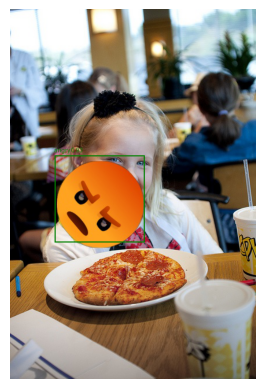

Processing Time:  2.233477830886841
angry 0.97


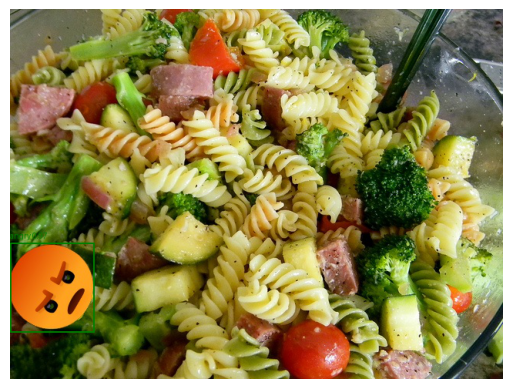

Processing Time:  0.635174036026001
care 0.95


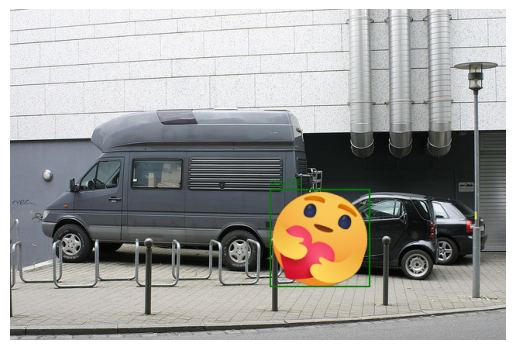

Processing Time:  0.6262831687927246
angry 0.96


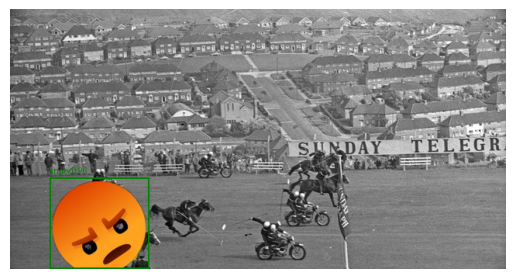

Processing Time:  0.09955525398254395
angry 0.88


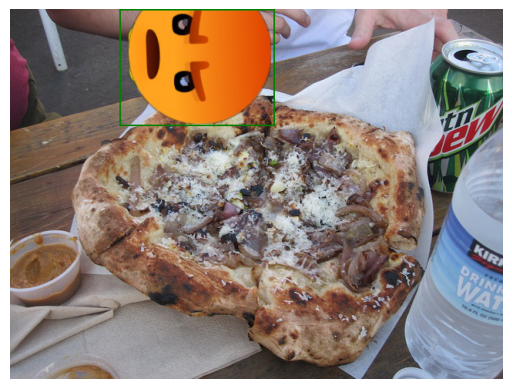

In [9]:
#Defining a function to perform inference on an image
def img_inference(img_path, threshold):
    #Opening the image
    image = Image.open(img_path)

    #Creating a draw object
    draw = ImageDraw.Draw(image)

    #Specifying font and size for the label
    font = ImageFont.load_default()

    #Preprocessing the image for the network
    image_np = read_image_bgr(img_path)
    image_np = preprocess_image(image_np)
    image_np, scale = resize_image(image_np)

    #Performing inference on the image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image_np, axis=0))
    print("Processing Time: ", time.time() - start)

    #Correcting the boxes for the image scale
    boxes /= scale

    #Iterating through the boxes
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        #Checking if the score is below the threshold
        if score < threshold:
            break

        #Extracting the box coordinates
        x1, y1, x2, y2 = box.astype(int)

        #Drawing the rectangle around the object
        draw.rectangle([x1, y1, x2, y2], outline="green", width=2)

        #Drawing the label and score
        label_text = "{} {:.2f}".format(labels_to_names[label], score)
        draw.text((x1, y1 - 15), label_text, fill="green", font=font)
        print(label_text)

    # #Saving the modified image
    # modified_img_path = "modified_" + os.path.basename(img_path)
    # image.save(modified_img_path)

    #Displaying the modified image
    # modified_image = plt.imread(modified_img_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

#Performing inference on the images
for img in images:
    img_inference(img, 0.5)



## Testing the Model

The model is converted to an inference model and is tested on the Testing Set. Its results are depicted through the use of a mAP graph for each label as well as a precision recall graph.

In [18]:
# model_path = "./snapshots/" + glob.glob('./snapshots/*.h5')[-2]
# inference_model_path = "./snapshots/inference_resnet50_csv.h5"

In [10]:
#Convert training model to inference model

#NOTE: CHANGE THE PATHS TO THE CORRECT PATHS

!python keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_10.h5 ./snapshots/inference_resnet50_csv.h5

!python keras-retinanet/keras_retinanet/bin/evaluate.py --gpu 0 --score-threshold 0.0 --save-path ./evaluation --no-resize\
        csv ../Object_Detection_Dataset/CSV/Test/labels.csv ./Classes.csv ./snapshots/inference_resnet50_csv.h5

2024-05-17 11:02:34.335879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
c:\Users\icemo\anaconda3\envs\retinanetTraining\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1 Physical GPUs, 1 Logical GPUs
Loading model, this may take a second...
262 instances of class wow with average precision: 0.6949
269 instances of class care with average precision: 0.7250
259 instances of class love with average precision: 0.8088
268 instances of class angry with average precision: 0.7214
265 instances of class haha with average precision: 0.6251
232 instances of class like with average precision: 0.7907
244 instances of class sad with average precision: 0.6040
Precision-Recall{0: (array([1.        , 1.        , 1.        , ..., 0.07514277, 0.07512019,
       0.07509763]), array([0.00381679, 0.00763359, 0.01145038, ..., 0.95419847, 0.95419847,
       0.95419847])), 1: (array([1.        , 1.        , 1.        , ..., 0.0933184 , 0.09328358,
       0.09324879]), array([0.00371747, 0.00743494, 0.01115242, ..., 0.92936803, 0.92936803,
       0.92936803])), 2: (array([1.        , 1.        , 1.        , ..., 0.11926606, 0.11920849,
       0.11915099]), array([0.003861  , 

2024-05-17 11:02:43.820695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 11:02:44.424947: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3472 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
c:\Users\icemo\anaconda3\envs\retinanetTraining\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instanc

In [ ]:
# # For prediction (To properly visualize the bounding boxes)
# visualise_path_1 = "./filesToReplace/visualization.py"
# visualise_copyTo_path= "./keras-retinanet/keras_retinanet/utils/visualization.py"

# copy_and_replace(visualise_path_1, visualise_copyTo_path)

In [11]:
#Loading the evaluation results
evaluation_results = np.load('./evaluation_results.npy', allow_pickle=True)

average_precisions = evaluation_results[0]
inference_time     = evaluation_results[1]
precision_recall   = evaluation_results[2]

In [12]:
#Reading the classes from the CSV file
df = pd.read_csv('./Classes.csv', header=None)
classes = df[0].tolist()

#Retrieving the average precisions for each class
aps = [average_precision[0] for label, average_precision in average_precisions.items()]

#Displaying the average precisions for each class
print('\033[35m' + 'Average Precisions for each class:' + '\033[0m')
for idx, ap in enumerate(aps):
    print(f'{classes[idx]:15}: {ap}')

#Displaying the mean average precision
mean_average_precision = np.mean(aps)
print(f'\n\033[37m' + 'Mean Average Precision (mAP):' + '\033[0m')
print(f'{mean_average_precision}')

Average Precisions for each class:
wow            : 0.6948798991156881
care           : 0.7250217575457671
love           : 0.8088364349341247
angry          : 0.7213826048281947
haha           : 0.6251379425023282
like           : 0.7907402772423087
sad            : 0.6040103790648612

Mean Average Precision (mAP):
0.7100013278904675


## Displaying Average Precision Graph

A bar chart is displayed depicting the Average Precision Value of each label.

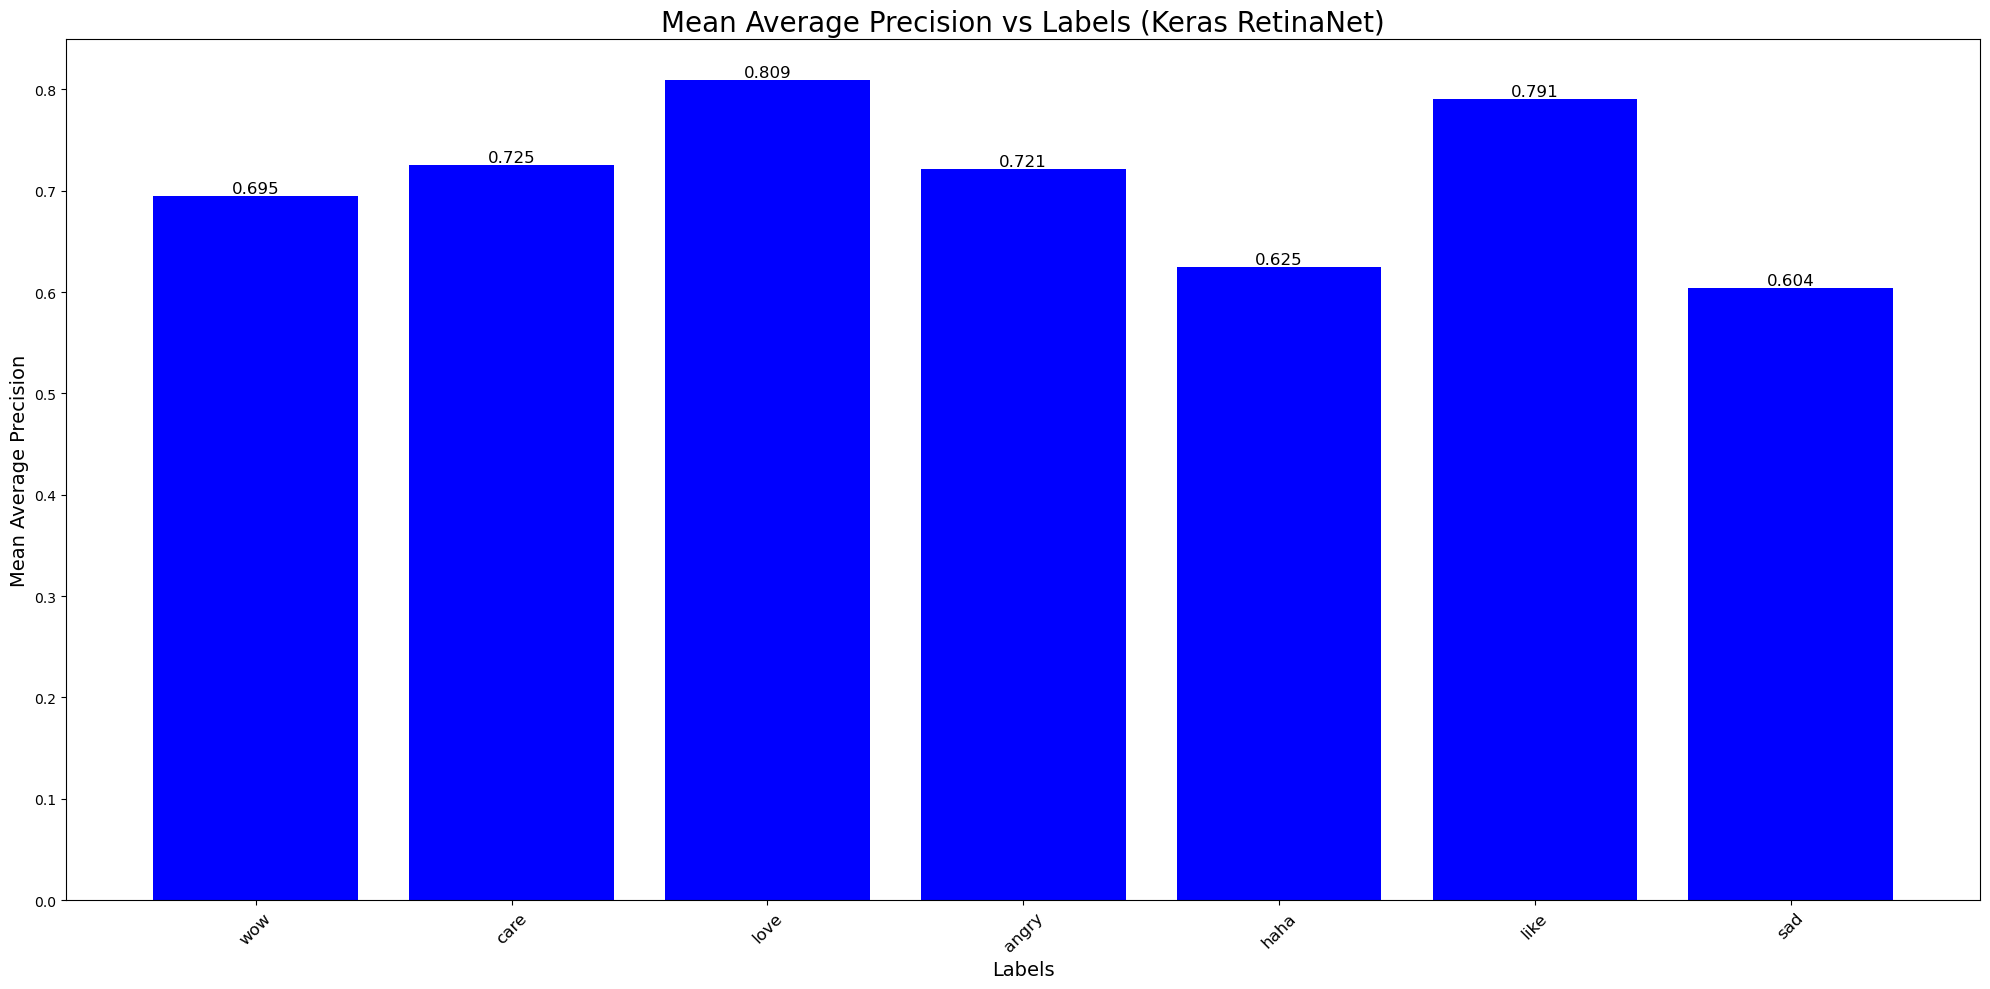

In [13]:
#Plotting the average precisions for each class
plt.figure(figsize=(20, 10))
plt.bar(list(average_precisions.keys()), list(aps), color='blue')

#Putting text on the bar chart
for idx, val in enumerate(aps):
    plt.text(idx, val, round(val, 3), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight': 500, 'size': 12})

#Setting the x-ticks to correspond to all labels
plt.gca().set_xticks(range(len(classes)))
plt.xticks(rotation=45, fontsize=12)

#Setting the labels to the actual class labels
plt.gca().set_xticklabels(classes)
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Mean Average Precision", fontsize=14)
plt.title("Mean Average Precision vs Labels (Keras RetinaNet)", fontsize=20)
plt.tight_layout()
plt.show()

## Displaying Precision-Recall Curve

The precision-recall curve is displayed using the results calculated earlier.

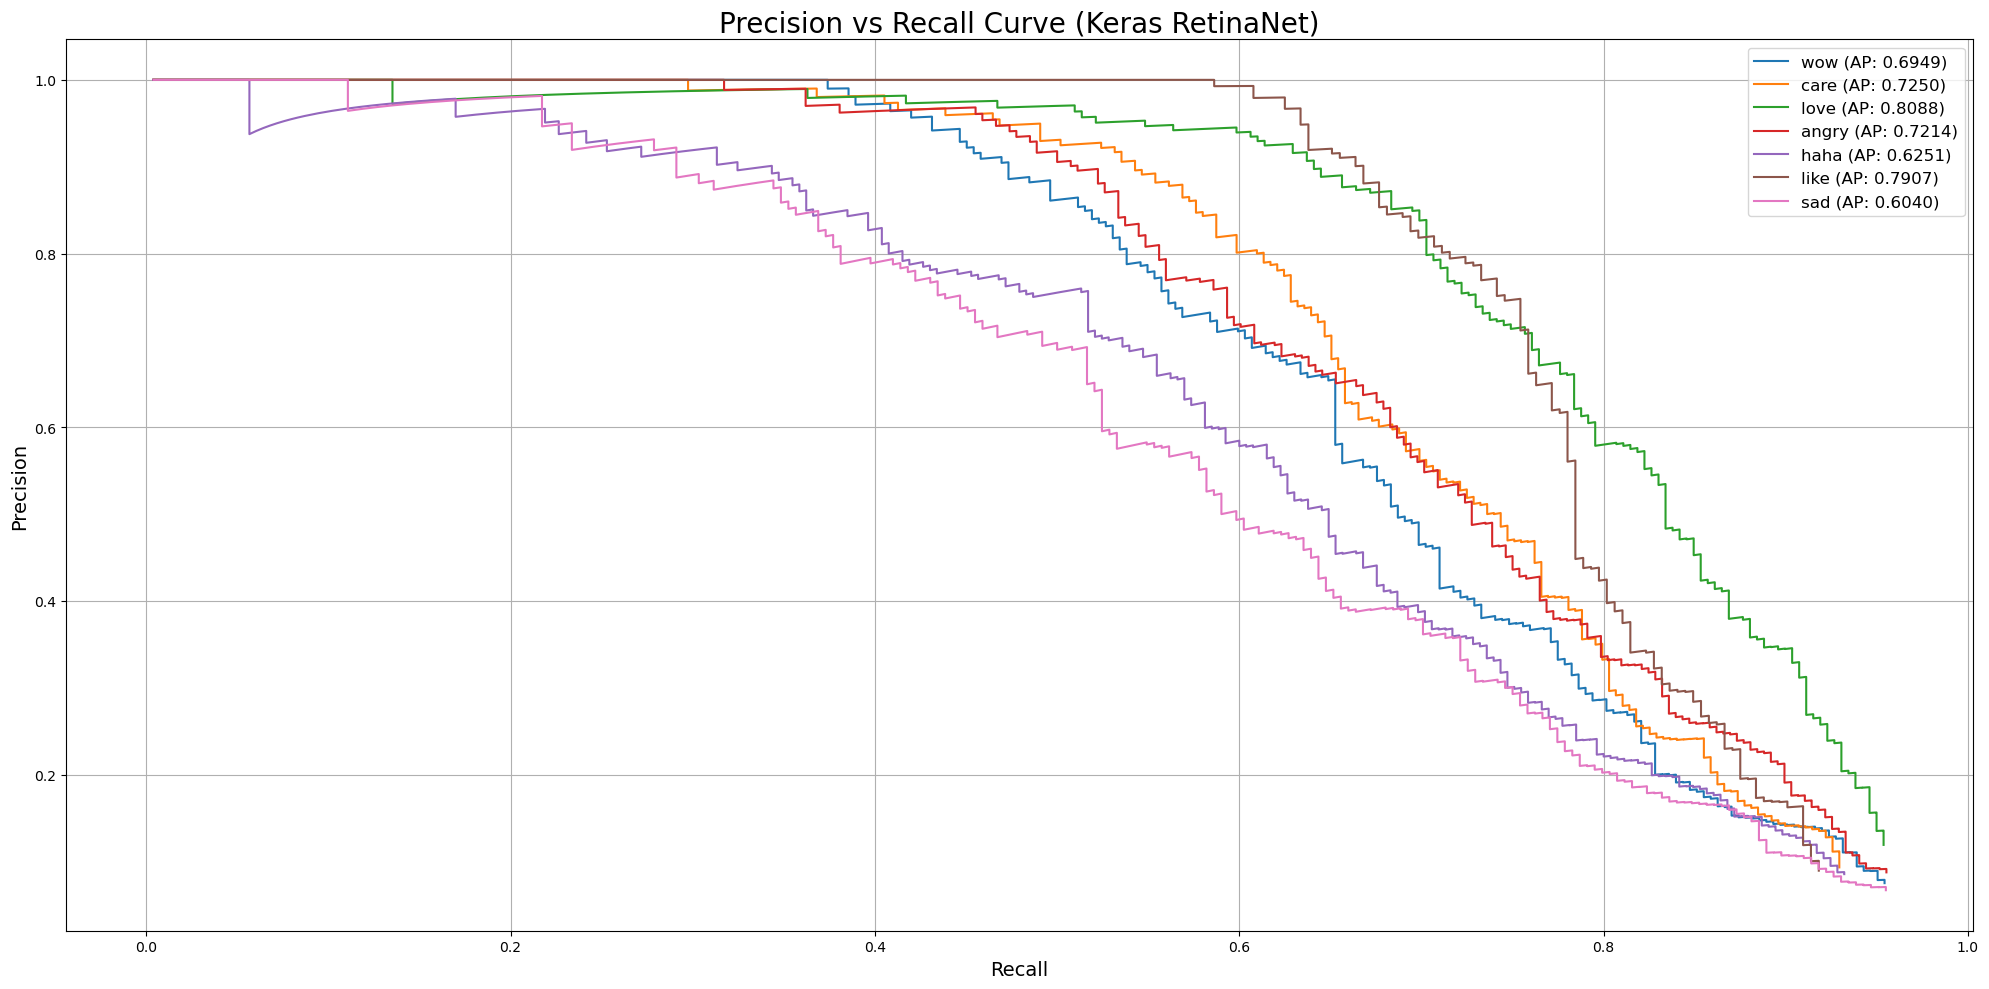

In [14]:
#Plotting the precision-recall curve
plt.figure(figsize=(20, 10))
#Iterating through the precision-recall values
for label, (precision_list, recall_list) in precision_recall.items():
    plt.plot(recall_list, precision_list, label=str(classes[label]) + " (AP: {:.4f})".format(aps[label]))
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision vs Recall Curve (Keras RetinaNet)", fontsize=20)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()


## Resetting Files Function

This function takes two input parameters:

- **csvFile** - The location of the filename to retrieve information from.
- **columnIndex** - The column of the file to search through.

The file is first opened and the directory of the images is removed.

In [16]:
annPathTrain="../Object_Detection_Dataset/CSV/Train/labels.csv"
annPathTest="../Object_Detection_Dataset/CSV/Test/labels.csv"

#Defining a function to remove the directory name from a CSV file's column
def removeDirectoryFromColumn(csvFile, columnIndex):
    #Reading the CSV file and storing its contents
    with open(csvFile, 'r') as file:
        reader = csv.reader(file)
        rows = list(reader)

    #Removing the directory name from each value in the specified column
    for row in rows:
        row[columnIndex] = os.path.basename(row[columnIndex])

    #Writing the modified data back to the CSV file
    with open(csvFile, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(rows)

removeDirectoryFromColumn(annPathTrain, 0)
removeDirectoryFromColumn(annPathTest, 0)